## Import Package

In [362]:
import pandas as pd 
import pyarrow.parquet as pq
import sqlite3
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy import stats

# Preprocess data 
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score

# Classification model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

# Evaluation Metric
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, f1_score
from sklearn import metrics

# save model
import joblib

## Read Data

In [279]:
ka_users = pd.read_csv('kabam_ds_interview/ka_users.csv')
ka_actions = pq.read_table('kabam_ds_interview/ka_actions.parquet').to_pandas()
con = sqlite3.connect('kabam_ds_interview/ka_devices.db')
ka_devices = pd.read_sql_query('select * from devices',con).drop('index',axis = 1)

## Explore ka_devices

In [19]:
ka_devices.head()

,uid_s,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,device_os_s,device_model_s
0,0,android,asus_x01ad,asus,3575.0,1024.0,3584.0,1024.0,8.0,720.0,adreno (tm) 506,android os 9 / api-28 (ww_phone-201905061022/1...,asus_x01ad
1,1,android,moto g (5),motorola,1867.0,512.0,1920.0,512.0,8.0,1080.0,adreno (tm) 505,android os 8.1.0 / api-27 (opps28.85-13-6/04442),moto g (5)
2,2,android,mi 6,xiaomi,3726.0,1024.0,3776.0,1024.0,8.0,1080.0,adreno (tm) 540,android os 8.0.0 / api-26 (opr1.170623.027/v10...,mi 6
3,3,android,oppo r7splus,oppo,3629.0,1024.0,3648.0,1024.0,8.0,1080.0,adreno (tm) 405,android os 5.1.1 / api-22 (lmy47v/eng.root.201...,oppo r7splus
4,4,android,cph1803,oppo,2816.0,1024.0,2816.0,1024.0,8.0,720.0,adreno (tm) 506,android os 8.1.0 / api-27 (opm1.171019.026/155...,cph1803


In [29]:
# Check unique values of each column
ka_devices.apply(lambda x: len(x.unique()))

uid_s                     2845931
platform_s                      2
device_mapped_s             18978
device_manufacturer_s        3030
device_mem_i                 2444
device_gmem_i                   9
device_mem_grouping_i         113
device_gmem_grouping_i          9
device_numcpu_i                13
device_height_i               216
device_gpu_s                  567
device_os_s                 75074
device_model_s              19085
dtype: int64

### First Thought
**device_mapped_s**: does not have much business value, large amount of levels, highly correlated to **device_model_s**, need to drop <br>
**device_model_s**: same as **device_mapped_s**, need to drop <br>
**device_os_s**: highly correlated with and has similar business value with **platform_s**, need to drop <br>
**device_mem_i**: have same business value with **device_mem_grouping_i**, need to drop <br>
**device_gmem_i**: same with **device_gmem_grouping_i**, need to drop <br>
**device_manufacturer_s**: should limit the levels of manufacturer eg. group manufacturer whose count is less than 1% of data as 'Other'; Drop NA rows<br> 
**device_gpu_s**: should limit the levels of gpu eg. group gpu whose count is less than 1% of data as 'Other'<br>
**device_mem_grouping_i**: numerical variable, check outliers<br>
**device_gmem_grouping_i**: numerical variable, check outliers<br>
**device_numcpu_i**: numerical variable, check outliers<br>
**device_height_i**: numerical variable, check outliers<br>

In [82]:
# Check Null Value
ka_devices.isnull().sum()

uid_s                     0
platform_s                0
device_mapped_s           5
device_manufacturer_s     5
device_mem_i              0
device_gmem_i             0
device_mem_grouping_i     0
device_gmem_grouping_i    0
device_numcpu_i           0
device_height_i           0
device_gpu_s              0
device_os_s               0
device_model_s            5
dtype: int64

In [ ]:
def select_features(df,col):
    '''
    Limit the levels of categorical variables.
    input: 
        df: DataFrame
        col: Columns in DataFrame
    
    This function is to limit the levels of categorical variables.
    Retain levels whose value counts are more than 1% of row number of data. 
    Replace levels whose value counts are less than 1% of row number of data as 'Other'
    '''
    l = len(df)
    # Retain the levels 
    value_counts =0.01 * l 
    mask = df[col].map(df[col].value_counts())< value_counts
    df[col] = df[col].mask(mask,'Other')
    
    return df
    
    

In [290]:
# Remove NA
ka_devices = ka_devices.dropna(subset=['device_manufacturer_s'])

In [ ]:
# Drop not useful features 
ka_devices = ka_devices.drop(['device_mapped_s','device_model_s','device_os_s','device_mem_i','device_gmem_i'],axis = 1)

In [ ]:
# Clean Data
ka_devices.device_manufacturer_s = ka_devices.device_manufacturer_s.str.strip()

In [124]:
ka_devices = select_features(ka_devices,'device_manufacturer_s')

<AxesSubplot:>

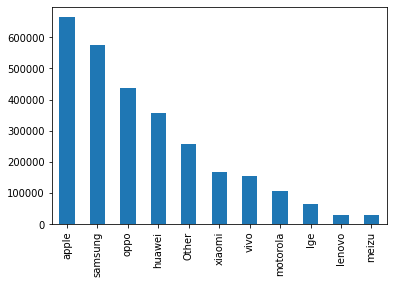

In [125]:
ka_devices.device_manufacturer_s.value_counts().plot(kind = 'bar')

In [126]:
ka_devices = select_features(ka_devices,'device_gpu_s')

<AxesSubplot:>

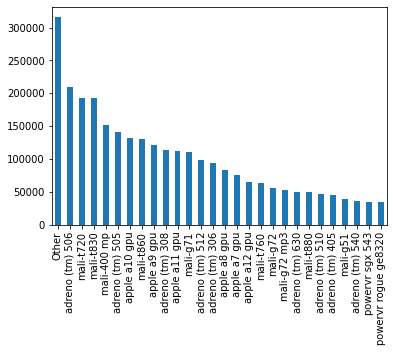

In [128]:
ka_devices.device_gpu_s.value_counts().plot(kind = 'bar')

In [131]:
ka_devices.describe()

,uid_s,device_mem_grouping_i,device_gmem_grouping_i,device_numcpu_i,device_height_i
count,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06,2.845930e+06
mean,1.422965e+06,2.701934e+03,8.180216e+02,5.814524e+00,8.908536e+02
std,8.215498e+05,2.871435e+03,5.216923e+02,2.426736e+00,2.548661e+02
min,0.000000e+00,3.840000e+02,1.280000e+02,1.000000e+00,2.400000e+02
25%,7.114822e+05,1.856000e+03,5.120000e+02,4.000000e+00,7.200000e+02
50%,1.422964e+06,2.816000e+03,1.024000e+03,8.000000e+00,8.000000e+02
75%,2.134448e+06,3.648000e+03,1.024000e+03,8.000000e+00,1.080000e+03
max,2.845930e+06,4.148160e+06,2.621440e+05,3.200000e+01,2.960000e+03


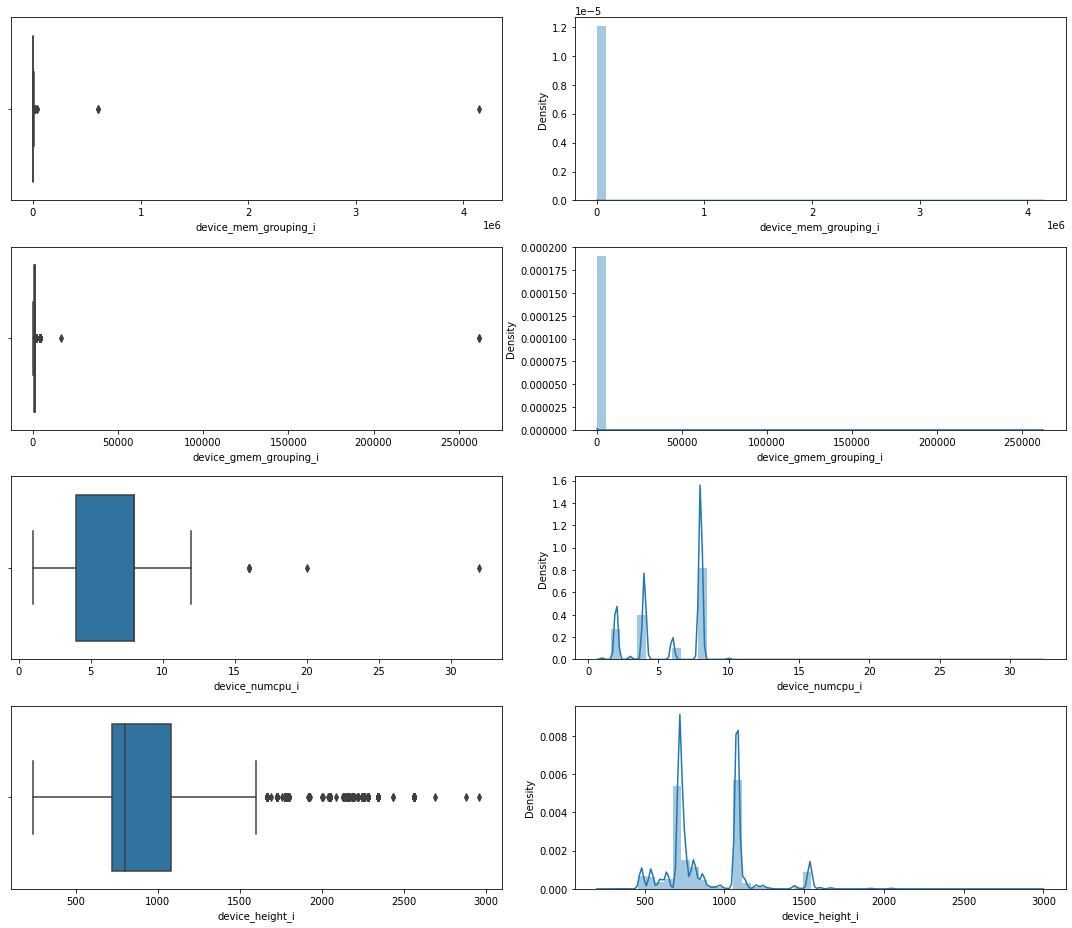

In [139]:
#Check numerical variables' distributions
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= ka_devices.device_mem_grouping_i, ax = ax[0,0])
sns.distplot(ka_devices.device_mem_grouping_i, ax = ax[0,1])
sns.boxplot(x= ka_devices.device_gmem_grouping_i, ax = ax[1,0])
sns.distplot(ka_devices.device_gmem_grouping_i, ax = ax[1,1])
sns.boxplot(x= ka_devices.device_numcpu_i, ax = ax[2,0])
sns.distplot(ka_devices.device_numcpu_i, ax = ax[2,1])
sns.boxplot(x= ka_devices.device_height_i, ax = ax[3,0])
sns.distplot(ka_devices.device_height_i, ax = ax[3,1])
plt.tight_layout()

### Remove Outliers based on Z score

In [245]:
ka_devices = ka_devices[~((np.abs(stats.zscore(ka_devices.device_gmem_grouping_i))>3)
           | (np.abs(stats.zscore(ka_devices.device_mem_grouping_i))>3)
          | (np.abs(stats.zscore(ka_devices.device_numcpu_i))>3))
                  ]

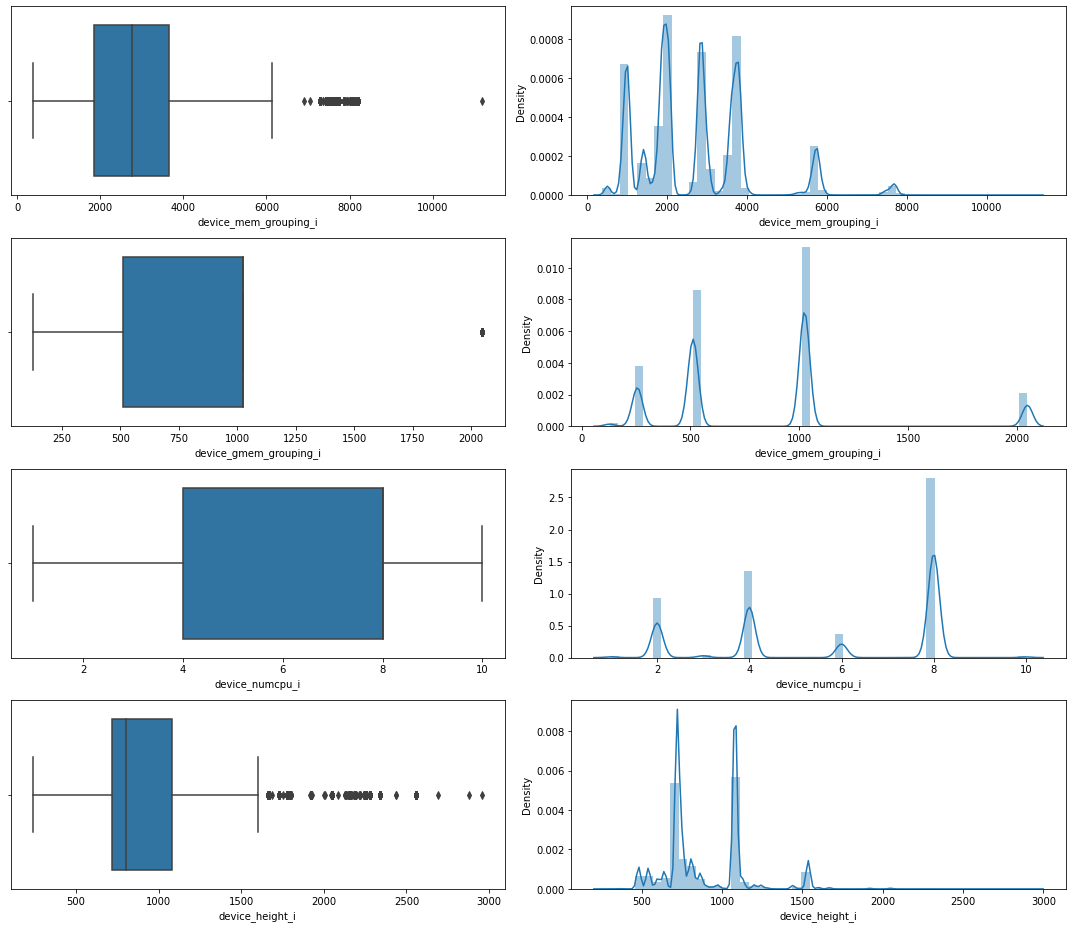

In [286]:
# Distibution after remove outliers
fig, ax = plt.subplots(4, 2, figsize = (15, 13))
sns.boxplot(x= ka_devices.device_mem_grouping_i, ax = ax[0,0])
sns.distplot(ka_devices.device_mem_grouping_i, ax = ax[0,1])
sns.boxplot(x= ka_devices.device_gmem_grouping_i, ax = ax[1,0])
sns.distplot(ka_devices.device_gmem_grouping_i, ax = ax[1,1])
sns.boxplot(x= ka_devices.device_numcpu_i, ax = ax[2,0])
sns.distplot(ka_devices.device_numcpu_i, ax = ax[2,1])
sns.boxplot(x= ka_devices.device_height_i, ax = ax[3,0])
sns.distplot(ka_devices.device_height_i, ax = ax[3,1])
plt.tight_layout()

## Explore ka_actions

In [146]:
ka_actions.head()

,uid_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
0,0,7.0,1.0,4.700000e+08,1693.0,592.0,0.0,429.0,446.0,364.0
1,1,2.0,1.0,6.120000e+08,197.0,197.0,0.0,0.0,60.0,125.0
2,2,2.0,1.0,3.900000e+08,313.0,313.0,0.0,0.0,89.0,129.0
3,3,3.0,1.0,6.610000e+08,1319.0,1319.0,0.0,0.0,275.0,200.0
4,4,4.0,1.0,3.147000e+09,148.0,148.0,0.0,0.0,58.0,138.0


In [148]:
ka_actions.game_stats_tutorial_complete.value_counts(dropna = False)

1.0    1751748
NaN    1088934
0.0       5249
Name: game_stats_tutorial_complete, dtype: int64

In [116]:
ka_actions.isnull().sum()

uid_s                                      0
logins                                    37
game_stats_tutorial_complete         1088934
game_stats_tutorial_complete_time    1094183
game_stats_xp                         762888
game_stats_xp1                        762888
game_stats_xp2                        762888
game_stats_xp3                        762888
redeemer_actions                       10282
scribe_actions                             1
dtype: int64

### First Thought
**logins**: check distribution and impute NA <br>
**game_stats_tutorial_complete**: More than 1/3 of data are Null, should drop this feature <br>
**game_stats_tutorial_complete_time**: More than 1/3 of data are Null, should drop this feature <br>
**game_stats_xp 1,2,3**: they all have same number of NA, which indicates players whose XP got missed in the first interval would also got missed in the rest of consecutive intervals. Since these features have good business value, instead of dropping, check distributions and impute NA<br>
**redeemer_actions**: check distribution and impute NA <br>
**scribe_actions**: delete the row with NA


In [182]:
# Remove NA
ka_actions = ka_actions[~ka_actions.scribe_actions.isnull()]

In [183]:
# Drop Features
ka_actions = ka_actions.drop(['game_stats_tutorial_complete','game_stats_tutorial_complete_time'],axis = 1)

In [203]:
ka_actions.describe()

,uid_s,logins,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions
count,2.845930e+06,2.845894e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.083043e+06,2.835649e+06,2.845930e+06
mean,1.422965e+06,2.961407e+00,8.966738e+02,4.481845e+02,1.290063e+02,7.907115e+01,1.312056e+02,1.332405e+02
std,8.215498e+05,2.254042e+00,7.353939e+03,6.952799e+03,5.728121e+02,5.018453e+02,2.295778e+02,9.406660e+01
min,0.000000e+00,1.000000e+00,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00
25%,7.114822e+05,2.000000e+00,9.000000e+01,8.000000e+01,0.000000e+00,0.000000e+00,2.500000e+01,7.000000e+01
50%,1.422966e+06,2.000000e+00,3.130000e+02,3.090000e+02,0.000000e+00,0.000000e+00,5.300000e+01,1.290000e+02
75%,2.134448e+06,3.000000e+00,7.860000e+02,5.950000e+02,0.000000e+00,0.000000e+00,1.340000e+02,1.670000e+02
max,2.845930e+06,8.790000e+02,1.000023e+07,1.000023e+07,4.604800e+04,4.697300e+04,9.078000e+03,1.072000e+04


In [242]:
ka_actions_sub = ka_actions.iloc[:,1:]

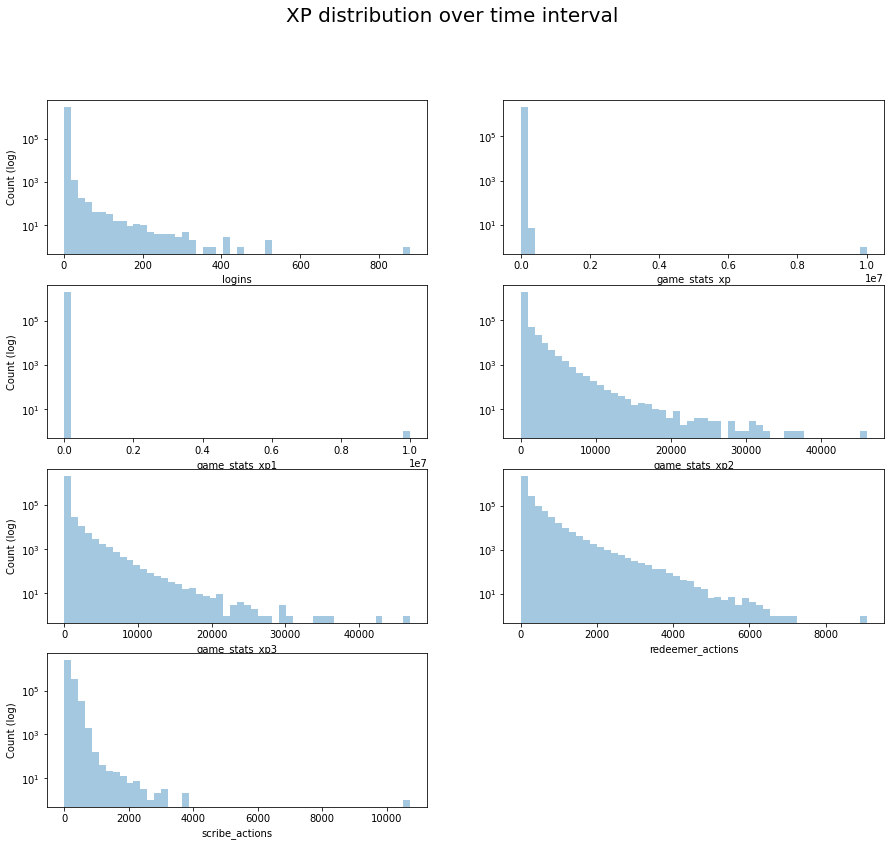

In [187]:
# Check all numerical feaures' distributions
fig = plt.figure(figsize=(15,13))
fig.suptitle("XP distribution over time interval",fontsize=20)
for i,col in enumerate(ka_actions_sub.columns):
    myax=fig.add_subplot(4,2,i+1)
    sns.distplot(ka_actions_sub[col].dropna(),kde=False,ax=myax,hist_kws={'log':True})
    if i % 2 == 0:
        myax.set_ylabel("Count (log)")

### Observations
Since all of the log distributions are right skewed, I should not identify outliers by z score or IQR.<br>
I should remove outliers based on visulizations and then impute NA with median. 

In [247]:
# Remove Outliers
ka_actions = ka_actions[~((ka_actions.logins > 800)|
          (ka_actions.game_stats_xp > 1000000)|
          (ka_actions.game_stats_xp2 > 40000)|
          (ka_actions.game_stats_xp3 > 40000) |
           (ka_actions.redeemer_actions > 8000)|
           (ka_actions.scribe_actions > 10000)
            )]

In [253]:
# impute NA with median
for i in ka_actions_sub.columns:
    ka_actions[i].fillna((ka_actions[i].median()),inplace = True)
    

## Explore ka_users

In [273]:
ka_users.head()

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend
0,0,EN,MY,asia,28800,14,3,0
1,1,ES,MX,americas,-18000,14,1,0
2,2,ZH-CN,CN,asia,28800,2,3,0
3,3,ZH-CN,CN,asia,28800,8,6,0
4,4,EN,IN,asia,19800,19,6,0


In [274]:
ka_users.apply(lambda x: len(x.unique()))

uid_s                   2845931
lang_s                       17
geo_s                       229
region_s                      6
tz_i                         34
local_time_join_hour         24
local_time_join_dow           7
total_spend                  79
dtype: int64

### First Thought
Feature lang_s, geo_s, region_s and tz_i have high correlation since all of them represent where the players located.<br> 
In particular, country level location of the user (geo_s) represent more detailed informantion than time zone of the users. To keep the model simple, I will drop the feature **tz_i** <br>
**geo_s**: limit the levels


In [275]:
ka_users.isnull().sum()

uid_s                     0
lang_s                    0
geo_s                   126
region_s                  0
tz_i                      0
local_time_join_hour      0
local_time_join_dow       0
total_spend               0
dtype: int64

In [280]:
# Drop tz_i and drop NA
ka_users = ka_users.drop(['tz_i'],axis = 1)
ka_users = ka_users.dropna(subset=['geo_s'])

In [305]:
# Limit the levels of geo_s
ka_users = select_features(ka_users,'geo_s')

<AxesSubplot:>

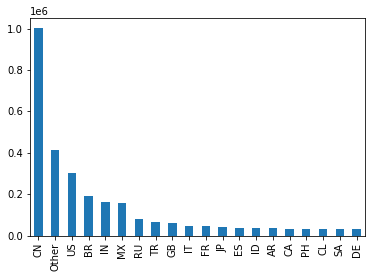

In [307]:
ka_users.geo_s.value_counts().plot(kind = 'bar')

## Preprocess Data

In [309]:
ka_ac_devi = pd.merge(ka_actions,ka_devices,on="uid_s")
ka = pd.merge(ka_ac_devi,ka_users,on="uid_s")
print("Merged table's shape is: ",ka.shape)

Merged table's shape is:  (2844766, 21)


In [310]:
ka.head()

,uid_s,logins,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,platform_s,device_manufacturer_s,...,device_gmem_grouping_i,device_numcpu_i,device_height_i,device_gpu_s,lang_s,geo_s,region_s,local_time_join_hour,local_time_join_dow,total_spend
0,0,7.0,1693.0,592.0,0.0,429.0,446.0,364.0,android,Other,...,1024.0,8.0,720.0,adreno (tm) 506,EN,Other,asia,14,3,0
1,1,2.0,197.0,197.0,0.0,0.0,60.0,125.0,android,motorola,...,512.0,8.0,1080.0,adreno (tm) 505,ES,MX,americas,14,1,0
2,2,2.0,313.0,313.0,0.0,0.0,89.0,129.0,android,xiaomi,...,1024.0,8.0,1080.0,adreno (tm) 540,ZH-CN,CN,asia,2,3,0
3,3,3.0,1319.0,1319.0,0.0,0.0,275.0,200.0,android,oppo,...,1024.0,8.0,1080.0,adreno (tm) 405,ZH-CN,CN,asia,8,6,0
4,4,4.0,148.0,148.0,0.0,0.0,58.0,138.0,android,oppo,...,1024.0,8.0,720.0,adreno (tm) 506,EN,IN,asia,19,6,0


In [311]:
# Convert 'total_spend' to Boolean
ka["whether_spend"] = np.where(ka['total_spend']==0, 0, 1)
ka_cf=ka.drop(['total_spend','uid_s'],axis=1)

### Check proportions of Target

In [318]:
y = ka_cf.whether_spend
num_spend = (y == 1).sum()
num_non_spend = (y == 0).sum()
num_player = len(ka_cf)

print('Number of money spending users: {0}, and the proportion is {1}%'.format(num_spend,
                                                                              round(num_spend/num_player*100,2)))
print('Number of not money spending users: {0}, and the proportion is {1}%'.format(num_non_spend,
                                                                                   round(num_non_spend/num_player*100,2)))

Number of money spending users: 32334, and the proportion is 1.14%
Number of not money spending users: 2812432, and the proportion is 98.86%


### Observations: 
From the proportions of target levels, I can identify this dataset is an imbalanced data.<br> 
I will 
1. Use stratify sampling technique when split data into training data and test data, so that binary target can have the same proportion in training and test dataset <br>
2. Combine random oversampling from the minority class using SMOTE and random undersampling from majority class. <br>
3. Used confusion matrix, specificity score, and AUC-ROC score to evaluate model

In [313]:
# Create dummy variables (one hot encoding) for categorical variables 
categorical_cols = ['platform_s','device_manufacturer_s','device_gpu_s', 'lang_s', 'geo_s', 'region_s']
ka_cf = pd.get_dummies(ka_cf,columns=categorical_cols)

In [315]:
ka_cf.shape

(2844766, 98)

In [322]:
# X are predictive variables 
X= ka_cf.drop('whether_spend',axis=1)
# y is target variables
y=ka_cf['whether_spend']

In [ ]:
# Split the data using stratified sampling 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42,stratify = y)
print(f'''% Negative class in Train = {np.round(y_train.value_counts(normalize=True)[1] * 100, 2)}
% Negative class in Test  = {np.round(y_test.value_counts(normalize=True)[1] * 100, 2)}''')

In [328]:
# Standardize numerical variable for training data and test data repectively 
numerical_cols = ['logins', 'game_stats_xp', 'game_stats_xp1', 'game_stats_xp2',
       'game_stats_xp3', 'redeemer_actions', 'scribe_actions','device_mem_grouping_i',
       'device_gmem_grouping_i', 'device_numcpu_i', 'device_height_i','local_time_join_hour',
       'local_time_join_dow']
scaler = StandardScaler()
X_train.loc[:,numerical_cols] = scaler.fit_transform(X_train.loc[:,numerical_cols])
X_test.loc[:,numerical_cols] = scaler.fit_transform(X_test.loc[:,numerical_cols])


In [346]:
# Oversampling minority class and undersampling majority calss in only training set 
over = SMOTE(sampling_strategy = 0.1, random_state=42)
under = RandomUnderSampler(sampling_strategy = 0.5, random_state=42)
steps = [('o',over),('u',under)]
pipeline = Pipeline(steps= steps)
X_sm, y_sm = pipeline.fit_resample(X_train,y_train)
print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


0    66.666667
1    33.333333
Name: whether_spend, dtype: float64

### Customized Evaluation Metric

In [ ]:
def show_scores(model,X_test,y_test):
    '''
    Show 
    1. Accurracy
    2. Specificity (TN / TN + FP)
    2. Confusion Matrix
    3. ROC Curve
    '''
    y_predict=model.predict(X_test)
    print(f'Accuracy = {accuracy_score(y_test, y_predict):.2f}\n')
    cm = confusion_matrix(y_test, y_predict)
    tn, fp, fn, tp = cm.ravel()
    print(f'Specificity = {tn/(tn+fp):.2f}\n')
    plt.figure(figsize=(8, 6))
    plt.title('Confusion Matrix', size=16)
    sns.heatmap(cm, annot=True, cmap='Blues')
    metrics.plot_roc_curve(model,X_test,y_test)
    plt.show()
    

## Ready for Modeling

### Baseline Model: Random Forest

Accuracy = 0.58



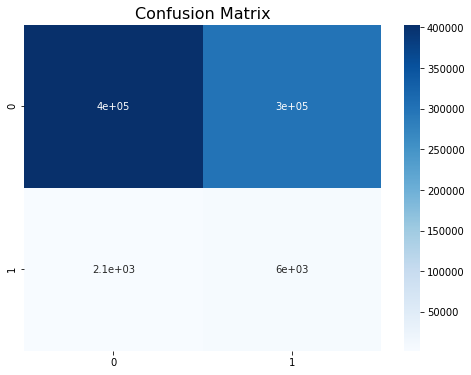

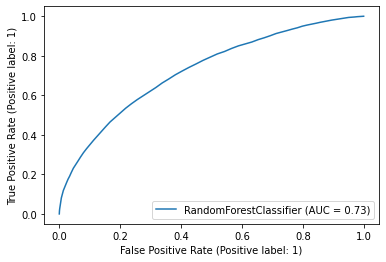

In [350]:
rf=RandomForestClassifier(random_state=42)
rf.fit(X_sm,y_sm)
show_scores(rf,X_test,y_test)

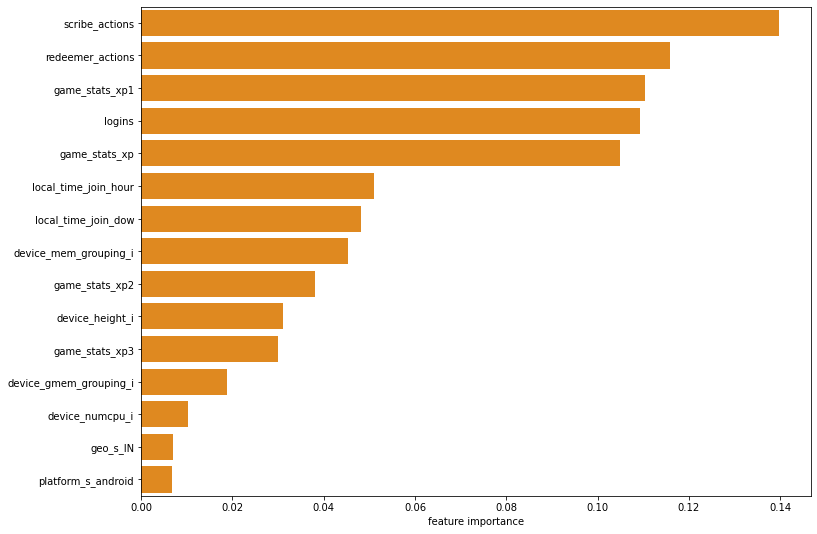

In [357]:
## Ploting Feature Importance
coefs_dict = {X_sm.columns[i] : rf.feature_importances_[i] for i in range(X_sm.shape[1])}
coefs_dict = sorted(coefs_dict.items(), key=lambda kv: kv[1], reverse=True)[:15]
plt.figure(figsize=(12,9))

plot = sns.barplot(y=[feature[0] for feature in coefs_dict],x=[feat_impr[1] for feat_impr in coefs_dict], color = "darkorange")
plot.set(xlabel = "feature importance");

In [ ]:
# Check relationship between target and important features
fig = plt.figure(figsize=(10,10))
fig.suptitle("Relationship between number of actions and whether spending money",fontsize=20)
myax=fig.add_subplot(2,2,1)
sns.boxplot(y='scribe_actions',x='whether_spend',data=ka_cf,palette="colorblind",width=0.5,ax=myax, showfliers=False)
myax=fig.add_subplot(2,2,2)
sns.boxplot(y='redeemer_actions',x='whether_spend',data=ka_cf,palette="colorblind",width=0.5,ax=myax, showfliers=False);

### Model Selection

In [ ]:
results_dict = {
                
                'Classifier':[],
                'Train Accuracy':[], 
                'Test Accuracy':[],
                'F-1 Score':[],
                'ROC AUC Score':[],
                'Time':[]
               }

models = {
    'random forest' : RandomForestClassifier(n_estimators=10),
    'logistic regression': LogisticRegression(),
    'SVM': SVC(),
    'lgbm': LGBMClassifier()
}

for model_name, model in models.items():
        start_time = time.time()
        model.fit(X_sm, y_sm)
        y_predict=model.predict(X_test)
        f1 = f1_score(y_test,y_predict)
        train_accuracy = model.score(X_sm, y_sm)
        test_accuracy = model.score(X_test, y_test)
        roc_auc = roc_auc_score(y_test,y_predict)
        end_time = time.time()
        Time = end_time - start_time
        results_dict['Classifier'].append(model_name)
        results_dict['Train Accuracy'].append(train_accuracy)
        results_dict['Test Accuracy'].append(test_accuracy)
        results_dict['F-1 Score'].append(f1)
        results_dict['ROC AUC Score'].append(roc_auc)
        results_dict['Time'].append(Time)

In [ ]:
results_df = pd.DataFrame(results_dict)
results_df

### Tunning Hyperparameters of LGBM

In [ ]:
lgbm = LGBMClassifier(random_state=42)
params ={'num_leaves': np.arange(100, 500,100), 
         'min_data_in_leaf': np.arange(300,500,100),
         'min_child_samples': np.arange(200, 500,100),
         'max_depth': np.arange(-1,30,10)}

gscv = RandomizedSearchCV(lgbm,params,cv=3,scoring='recall_micro')
gscv.fit(X_train,y_train)

In [ ]:
gscv.best_estimator_

In [ ]:
show_scores(gscv)

### Predict probability of spending money for test users

In [ ]:
prob = best_model.predict_proba(X_test)
final_result={'uid':uid,'proba_spend_money':prob[:,1]}
final_df = pd.DataFrame(final_result)

In [ ]:
# Save the model 
joblib.dump(gscv, 'gscv.sav')